In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd 
import seaborn as sns
from modules import preprocess
from matplotlib import pyplot as plt
import matplotlib as mpl



relevant_adm_ids = pd.read_csv("../data/preprocessed/US/cy_bench_16daybins_wheat_US_v8.csv")["adm_id"].unique()
state_selector = ['08', '20', '31', '40', '46', '48'] 
great_plains = {'08': 'Colorado', '20': 'Kansas', '31': 'Nebraska', '40': 'Oklahoma', '46': 'South Dakota', '48': 'Texas'}

%load_ext autoreload
%autoreload 2

In [2]:
# Read Yield data
yield_df = pd.read_csv("../data/CY-Bench/US/wheat/yield_wheat_US.csv", usecols=["adm_id", "harvest_year", "production", "yield", "harvest_area"])
yield_df = yield_df.assign(production_mio = yield_df["production"] / 1e6, harvested_area_mio = yield_df["harvest_area"] / 1e6)

# Read US shapefile
country_gpd = gpd.read_file("../data/shapefiles/US/tl_2023_us_county.shp")
country_gpd["adm_id"] = "US-" + country_gpd["STATEFP"].astype(str) + "-" + country_gpd["COUNTYFP"].astype(str)
country_gpd = country_gpd.cx[-125:-66, 24:50]
adm1_level = country_gpd.dissolve(by="STATEFP").to_crs("EPSG:4326").reset_index()[["STATEFP", "geometry"]]
#country_gpd = country_gpd[country_gpd["adm_id"].isin(yield_df["adm_id"].unique())] # Filter by CONTUS states that cultivate wheat (not study area yet)

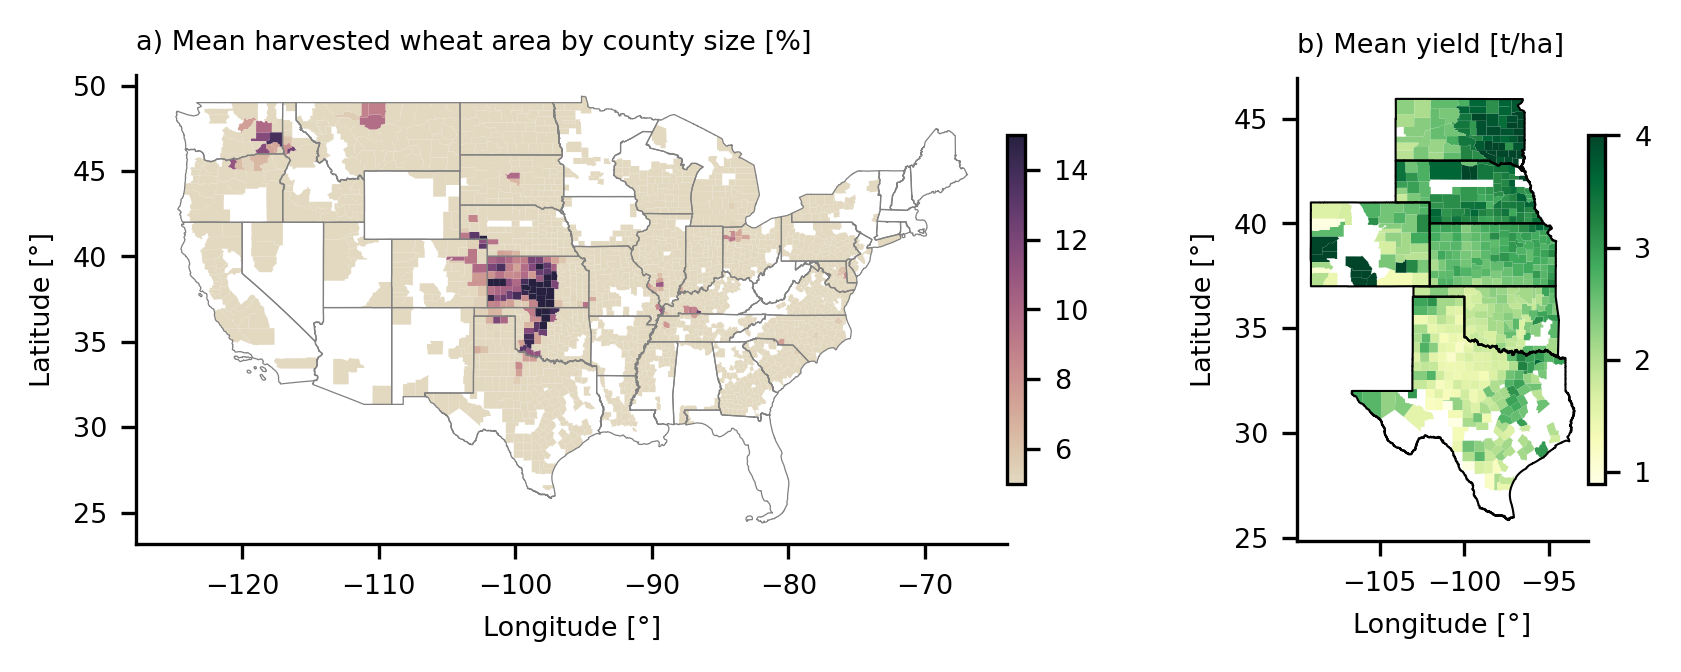

In [18]:


fontsize = 6.5
dpi = 300
mpl.rcParams['figure.dpi']= dpi
# Create subplots
fig, axd = plt.subplot_mosaic([['left', 'right']],
                              figsize=(468.3324*0.0138, (468.3324*0.0138/3)),  width_ratios=[0.75, 0.25])   

# a) Harvest area intensity
aggregated_yield_data_over_study_years = yield_df.loc[yield_df["harvest_year"].between(2004, 2023)].groupby("adm_id")[["yield", "production", "harvest_area", "production_mio", "harvested_area_mio"]].mean().reset_index()
adm2_crop_data = gpd.GeoDataFrame(aggregated_yield_data_over_study_years.merge(country_gpd, on="adm_id")).to_crs("EPSG:4326")
adm2_crop_data = adm2_crop_data.assign(intensity=100 * 10000 * adm2_crop_data["harvest_area"]/adm2_crop_data["geometry"].to_crs(epsg=32723).area) # convert ha to m2 for harvest area and times 100 for percentage
adm2_crop_data.plot(ax=axd["left"], column="intensity",  vmin=5, vmax=15, legend=True, edgecolor="none", linewidth=0, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True), legend_kwds={ 'orientation': 'vertical', "shrink":.7, 'pad': 0})
adm1_level.plot(ax=axd["left"], color="none", edgecolor="grey", linewidth=0.3)
axd["left"].set_title("a) Mean harvested wheat area by county size [%]", loc="left", fontsize=fontsize)
axd["left"].set_xlabel("Longitude [°]", fontsize=fontsize)
axd["left"].set_ylabel("Latitude [°]", fontsize=fontsize)
axd["left"].spines[['right', 'top']].set_visible(False)
axd["left"].tick_params(axis='both', labelsize=fontsize)
cbar = axd["left"].get_figure().get_axes()[-1]  # Assuming the colorbar is the last axis added
cbar.tick_params(labelsize=fontsize)

# b) Spatial distribution of Yield over Great Plains
adm2_crop_data.loc[(adm2_crop_data["adm_id"].isin(relevant_adm_ids))].plot(ax=axd["right"], column="yield", vmax=4, legend=True, cmap="YlGn", legend_kwds={'orientation': 'vertical', "shrink":.7, 'pad': 0, 'ticks': [1, 2, 3, 4]})
country_gpd.loc[country_gpd["STATEFP"].isin(state_selector)].dissolve("STATEFP").plot(ax=axd["right"], color="none", edgecolor="black", linewidth=0.5)
axd["right"].spines[['right', 'top']].set_visible(False)
axd["right"].set_title("b) Mean yield [t/ha]", loc="left", fontsize=fontsize)
axd["right"].set_xlabel("Longitude [°]", fontsize=fontsize)
axd["right"].set_ylabel("Latitude [°]", fontsize=fontsize)
axd["right"].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
axd["right"].tick_params(axis='both', labelsize=fontsize)
cbar = axd["right"].get_figure().get_axes()[-1]  # Assuming the colorbar is the last axis added
cbar.tick_params(labelsize=fontsize)

plt.savefig("figure2.png", dpi=300, bbox_inches='tight')


In [25]:
468.3324*0.0351

16.43846724

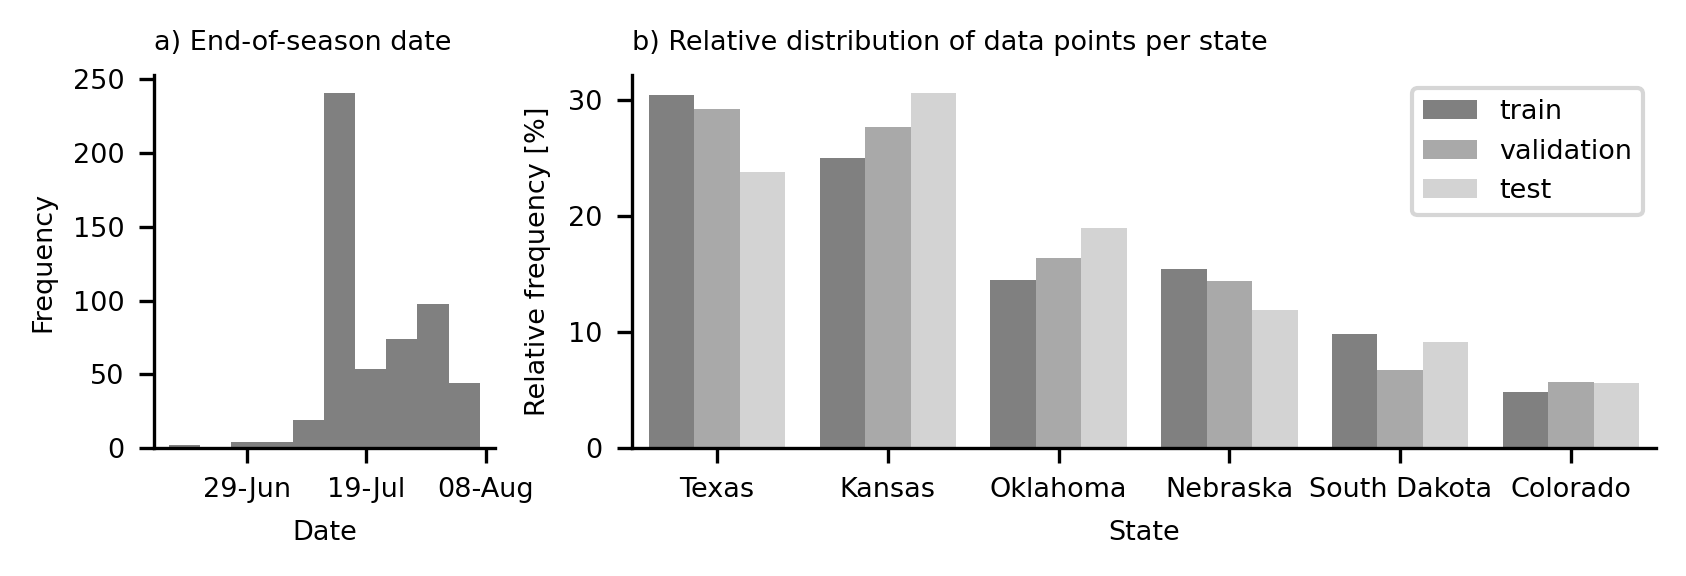

In [27]:
fontsize = 6.5
dpi = 300
mpl.rcParams['figure.dpi']= dpi

cm = 1/2.54  # centimeters in inches
# Create subplots
fig, axd = plt.subplot_mosaic([['left', 'right']],
                              figsize=(468.3324*0.0138, (468.3324*0.0138/4)),  width_ratios=[0.25, 0.75]) 


# a) Read and Prepare EOS data
crop_calendar = pd.read_csv("../data/CY-Bench/US/wheat/crop_calendar_wheat_US.csv", usecols=["adm_id", "eos"])
crop_calendar = crop_calendar[crop_calendar["adm_id"].isin(relevant_adm_ids)]
crop_calendar["eos"].plot(kind="hist", bins=10, ax=axd["left"], color="grey")
axd["left"].set_xticks([180, 200, 220])
axd["left"].set_xticklabels(pd.to_datetime([180, 200, 220], format='%j').strftime('%d-%b'), fontsize=fontsize);
axd["left"].set_title("a) End-of-season date", loc="left", fontsize=fontsize)
axd["left"].set_xlabel("Date", fontsize=fontsize)
axd["left"].set_ylabel("Frequency", fontsize=fontsize)
axd["left"].spines[['right', 'top']].set_visible(False)
axd["left"].tick_params(axis='y', labelsize=fontsize)


# b) number of observations per state
yield_df_state_count = yield_df.loc[(yield_df["harvest_year"].between(2004, 2023)) & (yield_df["adm_id"].isin(relevant_adm_ids))].assign(state=yield_df["adm_id"].str.split("-").str[1].replace(great_plains),
                                                               split=pd.cut(yield_df["harvest_year"], bins=[2003, 2017, 2020, 2024], labels=["train", "validation", "test"]))

yield_df_state_count.groupby(["state", "split"]).size()
relative_size = 100 * yield_df_state_count.groupby(["state", "split"]).size() / yield_df_state_count.groupby("split").size()
relative_size = relative_size.reset_index().rename(columns={0: "relative_size"})
state_order = ["Texas", "Kansas", "Oklahoma", "Nebraska", "South Dakota", "Colorado"]
relative_size["state"] = pd.Categorical(relative_size["state"], categories=state_order, ordered=True)
relative_size = relative_size.sort_values("state")
#relative_size
sns.barplot(relative_size, x="state", y="relative_size", hue="split", ax=axd["right"], palette=["grey", "darkgrey", "lightgrey"])
axd["right"].spines[['right', 'top']].set_visible(False)
axd["right"].set_title("b) Relative distribution of data points per state", loc="left" , fontsize=fontsize)
axd["right"].set_xlabel("State", fontsize=fontsize)
axd["right"].set_ylabel("Relative frequency [%]", fontsize=fontsize)
axd["right"].set_xticklabels(axd["right"].get_xticklabels(), fontsize=fontsize)
axd["right"].tick_params(axis='y', labelsize=fontsize)

plt.legend(fontsize=fontsize)
plt.savefig("figure3.png", dpi=300, bbox_inches='tight')


In [25]:
(yield_df_state_count.groupby(["state", "split"]).size().reset_index().rename(columns={0: "size"})
 .pivot(index="state", columns="split", values="size")
 .assign(sum=lambda x: x.sum(axis=1)).sort_values("sum", ascending=False)
 .transpose().assign(sum=lambda x: x.sum(axis=1)))

state,Texas,Kansas,Oklahoma,Nebraska,South Dakota,Colorado,sum
split,,,,,,,
train,1602,1317,763,811,518,256,5267
validation,236,223,132,116,54,46,807
test,187,241,149,94,72,44,787
sum,2025,1781,1044,1021,644,346,6861


### Plot annual state-level wheat yield for US great plains

### Figures